In [1]:
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ProgressBar

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
import logging


In [2]:
logging.getLogger("lightning").setLevel(logging.ERROR)


In [3]:
class RuftModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(5, 3)

    def forward(self, x):
        return self.layer(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch  
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = nn.functional.mse_loss(y_hat, y)
        self.log('val_loss', val_loss)
        return val_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [4]:
class CustomProgressBar(ProgressBar):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        super().on_train_batch_end(trainer, pl_module, outputs, batch, batch_idx)

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        pass
    
    def on_validation_epoch_end(self, trainer, pl_module):
        # Retrieve the logged validation loss
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None:
            print(f'Epoch {trainer.current_epoch + 1}: Validation Loss = {val_loss:.4f}')
        else:
            print(f'Epoch {trainer.current_epoch + 1}: Validation Loss = N/A')


In [5]:
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float)
        self.targets = torch.tensor(targets, dtype=torch.float)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


In [6]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.10,
    patience=3,
    verbose=False,
    mode='min'
)

In [7]:
data = pd.read_csv('data/synthetic_data.csv')  
X = data.iloc[:, :-3].values
y = data.iloc[:, -3:].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [8]:
train_dataset = CustomDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = CustomDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=512)

In [9]:
model = RuftModel()
trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[early_stop_callback, CustomProgressBar()],
    log_every_n_steps=50, 
    logger=True
)

trainer.fit(model, train_dataloader, val_dataloader);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-11-16 14:08:12.063650: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 14:08:12.085853: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has al

Epoch 1: Validation Loss = 105857.0859
Epoch 1: Validation Loss = 104573.1016
Epoch 2: Validation Loss = 104563.6797
Epoch 3: Validation Loss = 104554.0625
Epoch 4: Validation Loss = 104544.4453
Epoch 5: Validation Loss = 104534.7578
Epoch 6: Validation Loss = 104525.1875
Epoch 7: Validation Loss = 104515.6641
Epoch 8: Validation Loss = 104505.9531
Epoch 9: Validation Loss = 104496.4922
Epoch 10: Validation Loss = 104486.8984
Epoch 11: Validation Loss = 104477.2812
Epoch 12: Validation Loss = 104467.7891
Epoch 13: Validation Loss = 104458.1094
Epoch 14: Validation Loss = 104448.5312
Epoch 15: Validation Loss = 104438.9922
Epoch 16: Validation Loss = 104429.3281
Epoch 17: Validation Loss = 104419.7500
Epoch 18: Validation Loss = 104410.1562
Epoch 19: Validation Loss = 104400.5547
Epoch 20: Validation Loss = 104390.9141
Epoch 21: Validation Loss = 104381.3203
Epoch 22: Validation Loss = 104371.7578
Epoch 23: Validation Loss = 104362.1953
Epoch 24: Validation Loss = 104352.5938
Epoch 25: 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: Validation Loss = 99862.4766
Epoch 500: Validation Loss = 99853.0703


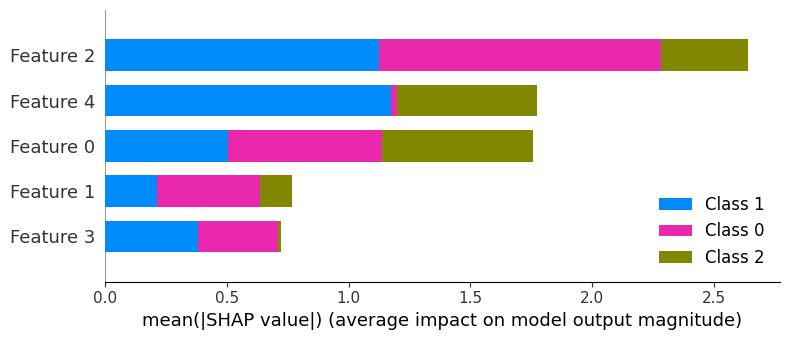

In [10]:
data_for_explanation = next(iter(val_dataloader))
features, _ = data_for_explanation

explainer = shap.DeepExplainer(model, features)
shap_values = explainer.shap_values(features)
shap.summary_plot(shap_values, features)